# Atividade 01 - Modelagem dinâmica e cinemática de robôs móveis de tração diferencial

Defina um cenário de teste e implemente computacionalmente os modelos dinâmicos desenvolvidos no artigo.

In [74]:
import numpy as np

def drawRobot(x,y,q,s,h):
    p=np.zeros(36).reshape(12,3)
    p[0,:]=[1,1/7,1/s]
    p[1,:]=[-3/7,1,1/s]
    p[2,:]=[-5/7,6/7,1/s]
    p[3,:]=[-5/7,5/7,1/s]
    p[4,:]=[-3/7,2/7,1/s]
    p[5,:]=[-3/7,0,1/s]
    p[6,:]=[-3/7,-2/7,1/s]
    p[7,:]=[-5/7,-5/7,1/s]
    p[8,:]=[-5/7,-6/7,1/s]
    p[9,:]=[-3/7,-1,1/s]
    p[10,:]=[1,-1/7,1/s]
    p[11,:]=[1,1/7,1/s]
    #
    p=s*p
    #
    r=np.zeros(6).reshape(3,2)
    r[0,:]=[np.cos(q),np.sin(q)]
    r[1,:]=[-np.sin(q),np.cos(q)]
    r[2,:]=[x,y]
    #
    p=np.dot(p,r)
    X=p[:,0]
    Y=p[:,1]
    h.plot(X,Y,'r-')

## Configuring the Environment

In [75]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# Parameters of Pioneer 3DX
Ra = 0.71      # Ohm
La = 0.00066   # H
Kb = 0.023     # V·s/rad
Kt = 0.029     # N·m/A
N = 38.3       # gear ratio

R = 0.1        # m (wheel radius)
L = 0.19       # m (half the wheelbase)
d = 0.05       # m (CoM offset)
mw = 1.0       # kg (wheel + actuator mass)
mc = 7.0       # kg (chassis mass)
Im = 0.0025    # kg·m²
Ir = 0.005     # kg·m²
Ic = 1.0       # kg·m²

m = mc + 2 * mw
I = Ic + mc * d**2 + 2 * mw * L**2 + 2 * Im

client = RemoteAPIClient()
sim = client.require('sim')

# Use the stepping mode
sim.setStepping(True)

PioneerP3DX = sim.getObjectHandle('/PioneerP3DX')
leftMotor = sim.getObjectHandle('/PioneerP3DX/leftMotor')
rightMotor = sim.getObjectHandle('/PioneerP3DX/rightMotor')

execution_time = 10
dt = sim.getSimulationTimeStep()
t_points = np.arange(0, execution_time, dt)
t_span = (0, execution_time)

initial_P3DXPos=sim.getObjectPosition(PioneerP3DX,-1)
initial_P3DXOri=sim.getObjectOrientation(PioneerP3DX,-1)


## DDMR Mathematical Model 

In [76]:
def M_bar():
    m11 = Ir + (R**2 / (4 * L**2)) * (m * L**2 + I)
    m12 = (R**2 / (4 * L**2)) * (m * L**2 - I)
    M = np.array([[m11, m12], [m12, m11]])
    return M

def V_bar(theta_dot):
    v = (R**2 / (4 * L**2)) * (mc * d * theta_dot)
    return np.array([[0, v], [-v, 0]])

B_bar = np.eye(2)

#  Voltage input (constant)
vaD = 3.0  # V
vaE = 3.0  # V
def voltage_input(t):
    return np.array([vaD, vaE])

# State vector: [iaD, iaE, phid, phie, phid_dot, phie_dot] 
def dynamics(t, x):
    iaD, iaE, phid, phie, phid_dot, phie_dot, theta, x_pos, y_pos = x
    va = voltage_input(t)
    
    # Electrical subsystem
    diaD = (va[0] - Kb * N * phid_dot - Ra * iaD) / La
    diaE = (va[1] - Kb * N * phie_dot - Ra * iaE) / La
    
    # Motor torques with N gear
    tau = Kt * N * np.array([iaD, iaE])
    
    # Dynamic Model -> Calculate the wheels velocities (phiddot)
    M = M_bar()
    theta_dot = (R / (2 * L)) * (phid_dot - phie_dot)
    V = V_bar(theta_dot)
    phiddot = np.linalg.inv(M) @ (-V @ np.array([phid_dot, phie_dot]) + B_bar @ tau)

    # Kinematic Model -> Calculate the robot pose
    # \dot{x}_a = (R/2) * (\dot{\phi}_R + \dot{\phi}_L) * cos(\theta)
    x_pos_dot = (R / 2) * (phid_dot + phie_dot) * np.cos(theta)
    
    # \dot{y}_a = (R/2) * (\dot{\phi}_R + \dot{\phi}_L) * sin(\theta)
    y_pos_dot = (R / 2) * (phid_dot + phie_dot) * np.sin(theta)

    return [diaD, diaE, phid_dot, phie_dot, phiddot[0], phiddot[1], theta_dot, x_pos_dot, y_pos_dot]


## Executing the Dynamic Model Simulation

Simulation time: 0.00 [s] 0.0 0.0
Simulation time: 0.05 [s] 2.561619720677643 2.561619720677643
Simulation time: 0.10 [s] 3.202089685621113 3.2020896856211127
Simulation time: 0.15 [s] 3.3565316630877002 3.3565316630877002
Simulation time: 0.20 [s] 3.3937738157677875 3.3937738157677875
Simulation time: 0.25 [s] 3.4027542709140874 3.4027542709140874
Simulation time: 0.30 [s] 3.4049198070694966 3.404919807069498
Simulation time: 0.35 [s] 3.405441946380219 3.4054419463802224
Simulation time: 0.40 [s] 3.4055678612389926 3.4055678612390086
Simulation time: 0.45 [s] 3.4055982242408676 3.4055982242409604
Simulation time: 0.50 [s] 3.40560557734746 3.4056055773474516
Simulation time: 0.55 [s] 3.405607356255028 3.4056073562535762
Simulation time: 0.60 [s] 3.4056077812861596 3.405607781277624
Simulation time: 0.65 [s] 3.4056079193014637 3.40560791913
Simulation time: 0.70 [s] 3.4056079108606983 3.4056079105175296
Simulation time: 0.75 [s] 3.4056079121166856 3.405607910729941
Simulation time: 0.80

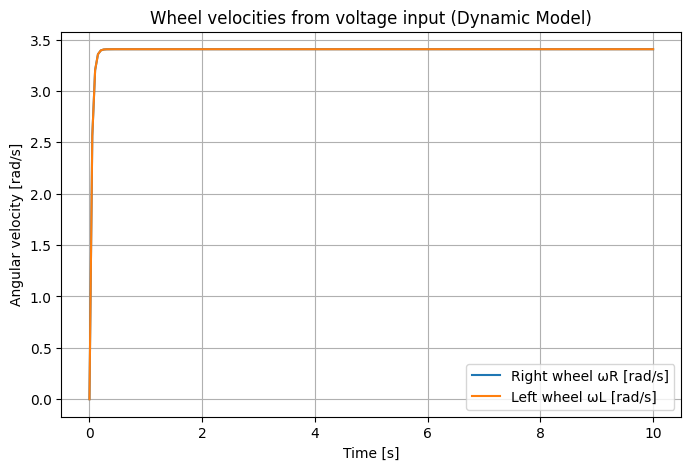

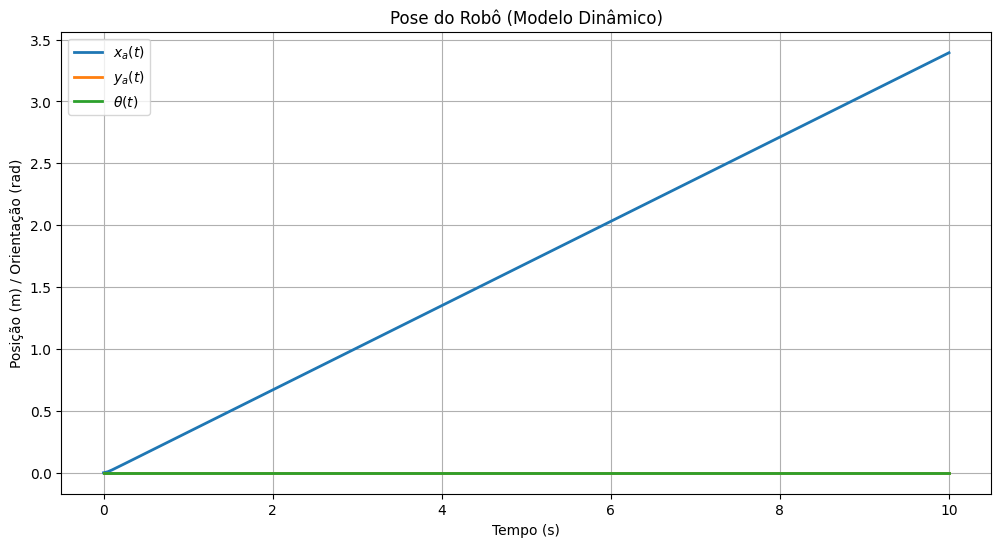

In [ ]:
x0 = np.zeros(9)
sol = solve_ivp(dynamics, t_span, x0, t_eval=np.linspace(*t_span, int(execution_time/dt)))

leftVel = sol.y[5]
rightVel = sol.y[4]

# Start the simulation on CoppeliaSim
sim.startSimulation()

for k in range(len(t_points)-1):

    # get robot pose
    P3DXPos=sim.getObjectPosition(PioneerP3DX,-1)
    P3DXOri=sim.getObjectOrientation(PioneerP3DX,-1)

    # save in the pose vector for future plot


    # set wheel velocities    
    sim.setJointTargetVelocity(leftMotor,leftVel[k])
    sim.setJointTargetVelocity(rightMotor,rightVel[k])

    print(f'Simulation time: {sim.getSimulationTime():.2f} [s]', leftVel[k], rightVel[k])
    sim.step()
sim.stopSimulation()

# --- Plot results ---
plt.figure(figsize=(8,5))
plt.plot(sol.t, sol.y[4], label='Right wheel ωR [rad/s]')
plt.plot(sol.t, sol.y[5], label='Left wheel ωL [rad/s]')
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity [rad/s]')
plt.legend()
plt.title('Wheel velocities from voltage input (Dynamic Model)')
plt.grid()
plt.show()

# Plotar Pose do Robô
plt.figure(figsize=(12, 6))
plt.plot(sol.t, sol.y[7], label='$x_a(t)$', lw=2)
plt.plot(sol.t, sol.y[8], label='$y_a(t)$', lw=2)
plt.plot(sol.t, sol.y[6], label='$\\theta(t)$', lw=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (m) / Orientação (rad)')
plt.title('Pose do Robô (Modelo Dinâmico)')
plt.legend()
plt.grid(True)
plt.show()